## Fuel Demand Data analysis

Currently d3ploy determines the demand from an equation. Here we compute such equation.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv ('supplied-motor-gasoline.csv')

# To retrieve the data as lists
# date = df['date'].tolist()
# volume = df['finished-motor-gasoline-supplied(thousand-barrels)'].tolist()  # [thousand-barrels]

date = df.iloc[:, :1].values
volume = df.iloc[:, 1].values  # [thousand-barrels]
volume = 1e3*volume  # [barrels]
volume = 42*volume  # [gallons]

# To convert data to dictionary
# zip(list(np.transpose(date)[0]), list(volume))
# data = dict(zip(list(np.transpose(date)[0]), list(volume)))
# data

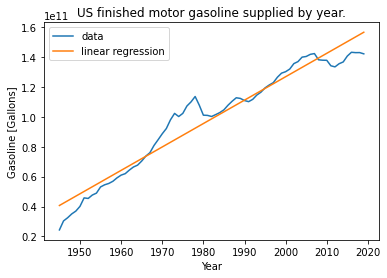

In [63]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression() 
lin.fit(date, volume) 

plt.plot(date, volume, label='data')
plt.plot(date, lin.predict(date), label='linear regression')
plt.legend(loc="upper left")
plt.title('US finished motor gasoline supplied by year.')
plt.ylabel('Gasoline [Gallons]')
plt.xlabel('Year')
plt.savefig("fuel-demand", dpi=300, bbox_inches="tight")

## D3ploy

D3ploy should be able to carry out this analysis on its own, but currently takes a function of time as the demand. If we can set this data as the demand in the initial years, then we wouldn't need the previous analysis.

D3ploy uses dictionaries. Retrieve the data and build a dictionary.

In [62]:
import pandas as pd
data = pd.read_csv('supplied-motor-gasoline.csv', header=0, index_col=0, squeeze=True).to_dict()

scaling = 42 * 1e3
total = {key: scaling * data[key] for key, values in data.items()}
print(total)

{1945: 24332406000.0, 1946: 30345504000.0, 1947: 32483136000.0, 1948: 35051100000.0, 1949: 36948282000.0, 1950: 40100466000.0, 1951: 45761772000.0, 1952: 45401580000.0, 1953: 47672646000.0, 1954: 48956334000.0, 1955: 53090688000.0, 1956: 54535992000.0, 1957: 55420554000.0, 1958: 56885262000.0, 1959: 59171784000.0, 1960: 61011552000.0, 1961: 61977132000.0, 1962: 64369536000.0, 1963: 66441732000.0, 1964: 67676616000.0, 1965: 70404768000.0, 1966: 73707144000.0, 1967: 76010886000.0, 1968: 80865834000.0, 1969: 84713790000.0, 1970: 88676658000.0, 1971: 92201256000.0, 1972: 98018676000.0, 1973: 102318552000.0, 1974: 100219392000.0, 1975: 102321576000.0, 1976: 107261028000.0, 1977: 110020680000.0, 1978: 113622936000.0, 1979: 107838066000.0, 1980: 101125374000.0, 1981: 100986816000.0, 1982: 100246608000.0, 1983: 101517528000.0, 1984: 102877362000.0, 1985: 104721162000.0, 1986: 107832270000.0, 1987: 110463738000.0, 1988: 112776132000.0, 1989: 112336140000.0, 1990: 110911164000.0, 1991: 110184648